# 生成四种LSTM需要输入的数据
#### 1. 基本价量数据
#### 2. 基本价量+价格形态特征
#### 3. 基本价量+宏观经济特征
#### 4. 基本价量+价格形态特征+宏观经济特征

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from filelock import FileLock
from math import *
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchkeras
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import torch.optim as optim
from filelock import FileLock
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
import ray
from ray import tune
from ray.air import session
from ray.air.checkpoint import Checkpoint
from ray.tune.schedulers import ASHAScheduler
import os

In [55]:
# 创建时间窗口
def dataWindow(dataset, lookback):
    
    # dataset = dataset.to_numpy()
    data = []
    for index in range(len(dataset)-lookback):
        data.append(dataset[index:index+lookback+1])
    data = np.array(data)
    return data


In [56]:
# 划分训练集、验证集、测试集
def spiltData(data, y_index, train_scale=0.7, val_scale=0.2, test_scale=0.1):

    test_size = int(np.round(test_scale*data.shape[0]))
    val_size = int(np.round(val_scale*data.shape[0]))
    train_size = data.shape[0] - test_size - val_size

    x_train = data[:train_size, :-1, :]
    y_train = data[:train_size, -1, y_index]
    x_val = data[train_size:train_size+val_size, :-1, :]
    y_val = data[train_size:train_size+val_size, -1, y_index]
    x_test = data[train_size+val_size:, :-1, :]
    y_test = data[train_size+val_size:, -1, y_index]
    return x_train, y_train, x_val, y_val, x_test, y_test

# 基本价量数据

In [57]:
# 基本价量数据
basic_data = pd.read_csv('../../data/final/hs300(2013-2022).csv').set_index("trade_date").sort_index()
basic_data.index = pd.to_datetime(basic_data.index, format='%Y%m%d')
basic_data

,close,open,high,low,vol
trade_date,,,,,
2013-01-04,2524.4090,2551.8140,2558.5290,2498.8920,97988182
2013-01-07,2535.9850,2518.0470,2545.9690,2511.6030,75167993
2013-01-08,2525.3300,2534.6470,2540.5130,2502.4900,71837100
2013-01-09,2526.1260,2518.1040,2534.2390,2504.2990,70231170
2013-01-10,2530.5690,2525.5900,2553.3520,2513.7290,71085862
...,...,...,...,...,...
2022-12-26,3843.4887,3830.5682,3856.8066,3827.5186,73005712
2022-12-27,3887.8540,3860.9054,3891.8497,3856.5800,77515350
2022-12-28,3871.2644,3874.9132,3884.7205,3854.9406,84424656


In [58]:
# 标准化
scaler1 = MinMaxScaler()
basic_data_scaled = scaler1.fit_transform(basic_data.values)
# 存储每个特征的最值，用于inverse
mins1 = basic_data.min()
maxs1 = basic_data.max()
y_min1 = mins1['close']
y_max1 = maxs1['close']

In [59]:
# 时间窗口+划分数据集
data1 = dataWindow(basic_data_scaled, 20)
x_train1, y_train1, x_val1, y_val1, x_test1, y_test1 = spiltData(data1, y_index = 0)

# 基本价量+价格形态数据

In [60]:
# 价格形态特征数据
price_form_data = basic_data.copy()
# 标准化
scaler2 = MinMaxScaler()
data_all2 = price_form_data.values
data_all2 = scaler2.fit_transform(data_all2)
# 存储每个特征的最值，用于inverse
mins2 = price_form_data.min()
maxs2 = price_form_data.max()
y_min2 = mins2['close']
y_max2 = maxs2['close']

In [61]:
lag = 20
data2 = dataWindow(data_all2, lag)
data2.shape

(2410, 21, 5)

In [62]:
# close的索引
close_index = price_form_data.columns.get_loc("close")
close_index

0

In [63]:
x_train2, y_train2, x_val2, y_val2, x_test2, y_test2 = spiltData(data2, y_index=close_index, train_scale=0.7, val_scale=0.2, test_scale=0.1)
print("x_train.shape:",x_train2.shape," y_train.shape:",y_train2.shape,"\n","x_val.shape:",x_val2.shape," y_val.shape:",y_val2.shape,"\n","x_test.shape:",x_test2.shape," y_test.shape:",y_test2.shape)

x_train.shape: (1687, 20, 5)  y_train.shape: (1687,) 
 x_val.shape: (482, 20, 5)  y_val.shape: (482,) 
 x_test.shape: (241, 20, 5)  y_test.shape: (241,)


In [64]:
def form(data: np.ndarray, scale=0.2, x_index=False, minMax=False):
    """
    获取价格形态向量
    :param data: 一维数据list
    :param scale: 特征点比例
    :param x_index: 是否带index（绘图可能需要）
    :param minMax: 是否进行minMax标准化
    :return: 一维形态向量
    """
    # 如果data不是list,转换为list
    if not isinstance(data, list):
        data = data.tolist()


    if minMax:
        # 归一化
        data = np.array(data)
        data = (data - np.min(data)) / (np.max(data) - np.min(data))

    # 关键价格点指标
    index = []
    for i in range(1, len(data)-1):
        index_i = np.abs(data[i]-(data[i-1]+data[i+1])/2)
        index.append(index_i)
    # 给index增加一个维度，数值为降序排列的序号
    index = np.array(index)
    index = np.expand_dims(index, axis=1)
    index = np.concatenate((index, np.arange(len(index)).reshape(-1, 1)), axis=1)
    threshold = int(scale*len(index))
    # 只保留第二维度数值排名前threshold的关键价格点
    index = index[index[:, 0].argsort()[::-1][:threshold+1]]
    # 按照第二维度数值从小到大排序
    index = index[index[:, 1].argsort()]

    # 取出关键价格点的下标
    temp = index[:, 1].astype(int)
    data_scale = []
    # 将data中下标为temp的数值取出，组成data_scale
    for i in range(len(temp)):
        data_scale.append(data[temp[i]])
    # 首尾
    data_scale.insert(0, data[0])
    data_scale.append(data[-1])

    # temp首位插入0
    temp = np.insert(temp, 0, 0)
    # temp尾部插入len(data)-1
    temp = np.append(temp, len(data)-1)


    if x_index:
        # 给data_scale增加一个维度，数值为temp
        data_scale = np.expand_dims(data_scale, axis=1)
        data_scale = np.concatenate((data_scale, temp.reshape(-1, 1)), axis=1)

    return data_scale

In [65]:
x_1 = x_train2[5][:,close_index]

x_1_expand = np.expand_dims(x_1, axis=1)
x_1_expand  = np.concatenate((x_1_expand  ,np.arange(len(x_1_expand )).reshape(-1, 1)), axis=1)
# x_1.shape


# 对x_1也归一化
x_1_scale = np.array(x_1)
x_1_scale = (x_1_scale - np.min(x_1_scale)) / (np.max(x_1_scale) - np.min(x_1_scale))

x_1_scale = np.expand_dims(x_1_scale, axis=1)
x_1_scale = np.concatenate((x_1_scale, np.arange(len(x_1_scale)).reshape(-1, 1)), axis=1)
x_1_scale.shape

(20, 2)

In [66]:
x_1_trend = form(x_1_expand.T[0], scale=0.2, x_index=True, minMax=True)
x_1_trend

array([[ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.32077071,  3.        ],
       [ 0.34012385,  9.        ],
       [ 0.70222546, 13.        ],
       [ 0.94540931, 19.        ]])

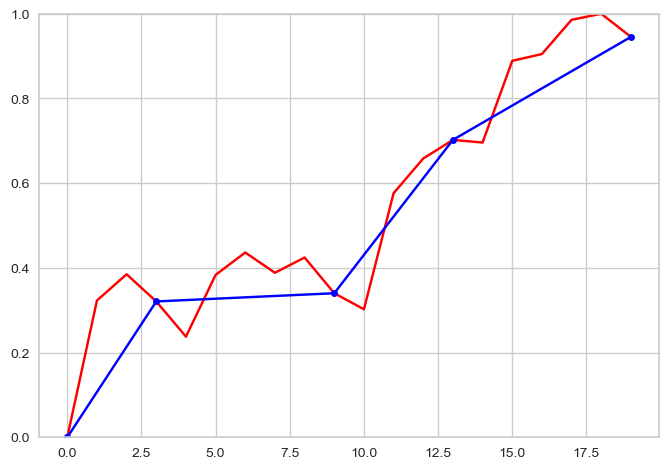

In [67]:
# 价格形态示例
plt.plot(x_1_scale.T[1], x_1_scale.T[0], label="原始数据",color="red")
plt.plot(x_1_trend.T[1], x_1_trend.T[0], label="价格形态向量",color="blue",
         marker="o", markersize=5,markeredgecolor="blue"
         )
# 设置y刻度范围
plt.ylim(0,1)

plt.show()

In [68]:
def getForm(data, close_index = 0, scale=0.2, x_index=False, minMax=False):
    """
    获取价格形态向量
    :param data: 传入训练集整体
    :param scale: 特征点比例
    :param x_index: 是否返回x轴下标
    :param minMax: 是否进行一组时间步内部的归一化
    :return: 返回增加所有训练集的价格形态向量
    """
    data_colse = data[:, :, close_index]
    data_form = []
    for i in range(len(data_colse)):
        data_form.append(form(data_colse.T[:,i], scale=scale, x_index=x_index, minMax=minMax))
    return np.array(data_form)

In [69]:
data2.shape

(2410, 21, 5)

In [70]:
x_train_form2 = getForm(data2, scale=0.2, x_index=False, minMax=True)

In [71]:
x_train_form2

array([[0.15832353, 0.18200727, 0.        , 0.36087722, 0.38265012,
        1.        ],
       [0.19922734, 0.17877401, 0.        , 0.35446642, 0.37585254,
        1.        ],
       [0.14595503, 0.16411794, 0.        , 0.32540692, 0.34503978,
        1.        ],
       ...,
       [0.14596466, 0.14596466, 0.39141152, 0.77024374, 0.382307  ,
        0.25317158],
       [0.39141152, 0.39141152, 0.77024374, 0.72794829, 0.382307  ,
        0.16751556],
       [0.25130951, 0.77024374, 0.72794829, 0.382307  , 0.08980952,
        0.2553442 ]])

In [72]:
x_train_form2.shape

(2410, 6)

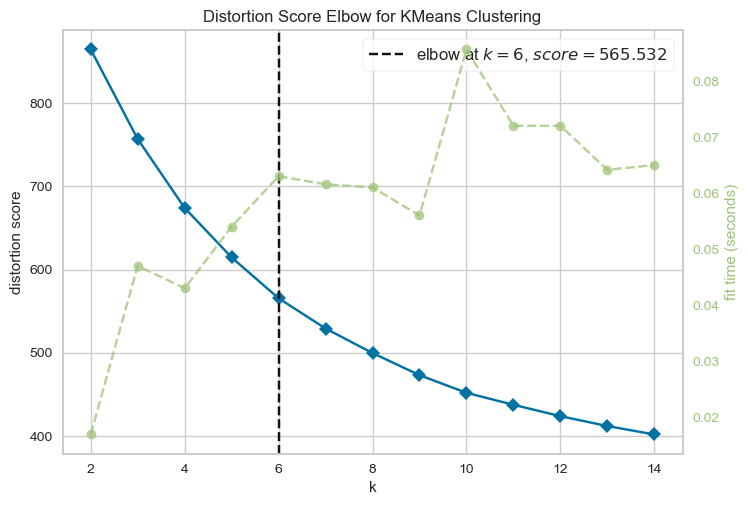

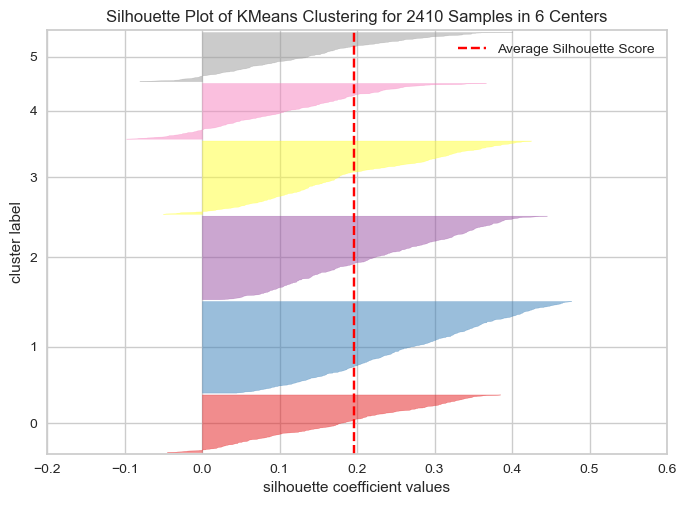

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 2410 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [73]:
# K-means聚类
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

# 加载数据
X2 = x_train_form2

# 定义KMeans模型
k_model2 = KMeans()

# 使用elbow方法确定最佳的k值
visualizer = KElbowVisualizer(k_model2, k=(2,15))
visualizer.fit(X2)
visualizer.show()

# 根据最佳的k值进行聚类
best_k = visualizer.elbow_value_
model_k2 = KMeans(n_clusters=best_k)
model_k2.fit(X2)

# 可视化聚类结果


visualizer = SilhouetteVisualizer(model_k2)
visualizer.fit(X2)
visualizer.show()


In [74]:
# 获取聚类结果
y_train_form2 = model_k2.labels_
y_train_form2


array([1, 1, 1, ..., 5, 5, 2])

In [75]:
# 查看y_train_form2中各个类别的数量
pd.Series(y_train_form2).value_counts()


1    537
2    490
3    430
0    338
4    327
5    288
dtype: int64

In [76]:
# 针对每一种类别，选出一组数据
x_train_form_0 = np.mean((x_train_form2[y_train_form2 == 0]), axis=0)
x_train_form_1 = np.mean((x_train_form2[y_train_form2 == 1]), axis=0)
x_train_form_2 = np.mean((x_train_form2[y_train_form2 == 2]), axis=0)
x_train_form_3 = np.mean((x_train_form2[y_train_form2 == 3]), axis=0)
x_train_form_4 = np.mean((x_train_form2[y_train_form2 == 4]), axis=0)
x_train_form_5 = np.mean((x_train_form2[y_train_form2 == 5]), axis=0)

In [77]:
x_train_form_0.shape

(6,)

In [78]:
x_train_form_0

array([0.70503013, 0.77652156, 0.78468884, 0.7528491 , 0.45740766,
       0.17558824])

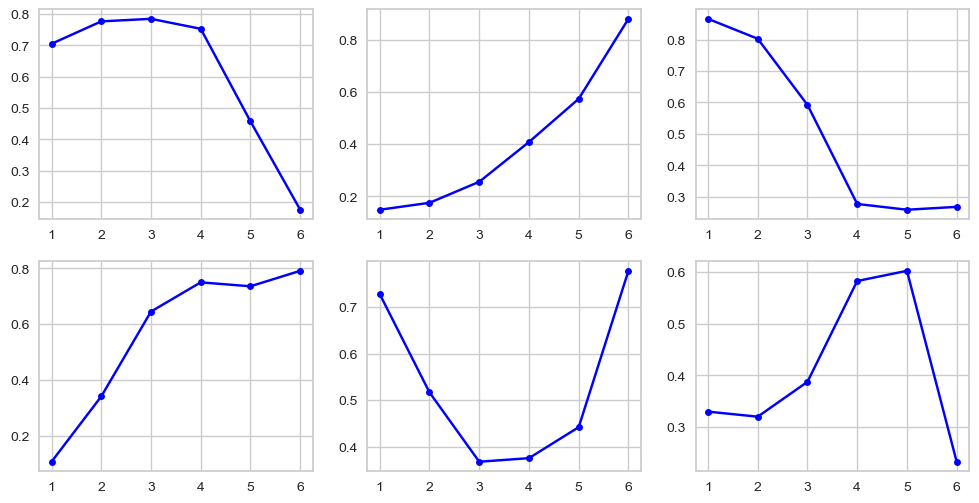

In [79]:
# 创建3*2画布。以整数0~12为横轴，以x_train_form的第二维度数值为纵轴，画出折线图
plt.figure(figsize=(12, 6))
plt.subplot(2, 3, 1)
plt.plot(np.arange(1, 7), x_train_form_0, label="价格形态向量0",color="blue",
         marker="o", markersize=5,markeredgecolor="blue"
         )
plt.subplot(2, 3, 2)
plt.plot(np.arange(1, 7) ,x_train_form_1, label="价格形态向量1",color="blue",
         marker="o", markersize=5,markeredgecolor="blue"
         )
plt.subplot(2, 3, 3)
plt.plot(np.arange(1, 7), x_train_form_2, label="价格形态向量2",color="blue",
         marker="o", markersize=5,markeredgecolor="blue"
         )
plt.subplot(2, 3, 4)
plt.plot(np.arange(1, 7), x_train_form_3, label="价格形态向量3",color="blue",
         marker="o", markersize=5,markeredgecolor="blue"
         )
plt.subplot(2, 3, 5)
plt.plot(np.arange(1, 7), x_train_form_4, label="价格形态向量4",color="blue",
         marker="o", markersize=5,markeredgecolor="blue"
         )
plt.subplot(2, 3, 6)
plt.plot(np.arange(1, 7), x_train_form_5, label="价格形态向量5",color="blue",
         marker="o", markersize=5,markeredgecolor="blue"
         )
plt.show()

In [80]:
def add_form(data_all, form_data):
    data_all = data_all[lag:,:,:]
    form_onehot = np.zeros((form_data.shape[0], best_k))
    form_onehot[np.arange(form_data.shape[0]), form_data] = 1
    form_onehot = dataWindow(form_onehot,lookback=lag)[:data_all.shape[0],:,:]
    data_all = np.concatenate((data_all, form_onehot), axis=2)
    return data_all

In [81]:
data2 = add_form(data_all=data2, form_data=y_train_form2)

In [82]:
x_train2, y_train2, x_val2, y_val2, x_test2, y_test2 = spiltData(data2, y_index=close_index, train_scale=0.7, val_scale=0.2, test_scale=0.1)
print("x_train.shape:",x_train2.shape," y_train.shape:",y_train2.shape,"\n",
      "x_val.shape:",x_val2.shape," y_val.shape:",y_val2.shape,"\n",
      "x_test.shape:",x_test2.shape," y_test.shape:",y_test2.shape)

x_train.shape: (1673, 20, 11)  y_train.shape: (1673,) 
 x_val.shape: (478, 20, 11)  y_val.shape: (478,) 
 x_test.shape: (239, 20, 11)  y_test.shape: (239,)


# 基本价量+宏观经济特征

In [83]:
marco_data = pd.read_csv("../../data/final/marcoData_selected.csv").rename(columns={"指标名称":"trade_date"}).set_index("trade_date")
marco_data.index = pd.to_datetime(marco_data.index, format='%Y%m')
marco_data.head()

,7天回购利率:加权平均:最近1月(B1M):月:平均值,短期贷款利率:6个月(含)(月),中债国债到期收益率:5年:月:平均值,中间价:新西兰元兑人民币:月:平均值,银行间同业拆借:成交金额:30天:当月值,金融机构:本外币贷款余额:初值:同比,金融机构:新增人民币贷款:当月值,金融机构:各项存款余额:同比,货币当局:储备货币:其他存款性公司存款,货币当局:国外负债,...,GDP:初步核算数:当季同比:月:均值,社会融资规模:当月值,社会融资规模:累计值,上证所:平均市盈率,上证所:A股平均市盈率,上证综合指数:月:平均值,上证A股指数:月:平均值,换手率:上证综合指数:月:平均值,涨跌幅:上证综合指数:月:平均值,市净率:万得全A:月:平均值
trade_date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,3.174647,5.6,3.276600,5.223280,336.89,16.1,6200.0,14.6,184549.71,1076.51,...,2.566667,10705.0,36151.45,12.90,12.89,2380.363400,2491.569000,0.619347,-0.047874,1.862261
2013-02-01,3.301505,5.6,3.291057,5.146524,766.60,16.0,10625.0,15.6,192318.96,1295.98,...,2.566667,25503.0,61654.00,12.19,12.18,2296.431095,2403.647571,0.561943,-0.256607,1.788571
2013-03-01,3.211562,5.6,3.204062,5.237842,588.26,16.1,7923.0,16.2,190587.96,1267.65,...,2.500000,17629.0,79283.00,11.89,11.89,2211.796056,2314.957778,0.420194,-0.142696,1.688423
2013-04-01,3.415759,5.6,3.129682,5.060916,748.42,15.6,6694.0,16.2,189818.91,1220.51,...,2.500000,11871.0,91154.00,11.81,11.81,2264.514773,2370.196409,0.525509,0.252207,1.697471
2013-05-01,5.566932,5.6,3.323942,4.852271,160.51,15.1,8628.0,14.3,197945.13,1127.07,...,2.500000,10375.0,101529.00,10.17,10.16,2119.149176,2217.954235,0.455676,-0.869303,1.632460


In [84]:
# 合并日频和月频数据的函数
def dmMerge(df_day, df_month):
    """
    :param df_day: 日频数据，index为年月日
    :param df_month: 月品数据：index为年月
    :return:
    """
    df_day1 = df_day.copy()
    # 在日频数据中增加宏观月度特征，取值初始化为nan
    df_day1[df_month.columns] = np.nan
    # 合并
    for date1 in df_day1.index:
        date_YM = date1.strftime("%Y-%m")
        if date_YM in df_month.index.strftime("%Y-%m").tolist():
            
            # df_day1.at[date1, df_month.columns.to_list()] = df_month.loc[date_YM].values.tolist()[0]
            df_day1.loc[date1, df_month.columns.to_list()] = df_month.loc[date_YM].values[0]


    return df_day1

In [85]:
basic_marco = dmMerge(df_day = basic_data, df_month = marco_data).dropna(axis=0, how='any')
basic_marco

,close,open,high,low,vol,7天回购利率:加权平均:最近1月(B1M):月:平均值,短期贷款利率:6个月(含)(月),中债国债到期收益率:5年:月:平均值,中间价:新西兰元兑人民币:月:平均值,银行间同业拆借:成交金额:30天:当月值,...,GDP:初步核算数:当季同比:月:均值,社会融资规模:当月值,社会融资规模:累计值,上证所:平均市盈率,上证所:A股平均市盈率,上证综合指数:月:平均值,上证A股指数:月:平均值,换手率:上证综合指数:月:平均值,涨跌幅:上证综合指数:月:平均值,市净率:万得全A:月:平均值
trade_date,,,,,,,,,,,,,,,,,,,,,
2013-01-04,2524.4090,2551.8140,2558.5290,2498.8920,97988182,3.174647,5.60,3.276600,5.22328,336.89,...,2.566667,10705.0,36151.45,12.90,12.89,2380.363400,2491.569000,0.619347,-0.047874,1.862261
2013-01-07,2535.9850,2518.0470,2545.9690,2511.6030,75167993,3.174647,5.60,3.276600,5.22328,336.89,...,2.566667,10705.0,36151.45,12.90,12.89,2380.363400,2491.569000,0.619347,-0.047874,1.862261
2013-01-08,2525.3300,2534.6470,2540.5130,2502.4900,71837100,3.174647,5.60,3.276600,5.22328,336.89,...,2.566667,10705.0,36151.45,12.90,12.89,2380.363400,2491.569000,0.619347,-0.047874,1.862261
2013-01-09,2526.1260,2518.1040,2534.2390,2504.2990,70231170,3.174647,5.60,3.276600,5.22328,336.89,...,2.566667,10705.0,36151.45,12.90,12.89,2380.363400,2491.569000,0.619347,-0.047874,1.862261
2013-01-10,2530.5690,2525.5900,2553.3520,2513.7290,71085862,3.174647,5.60,3.276600,5.22328,336.89,...,2.566667,10705.0,36151.45,12.90,12.89,2380.363400,2491.569000,0.619347,-0.047874,1.862261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-24,3756.8082,3791.5399,3804.8987,3751.3818,101073447,2.078113,4.35,2.680843,4.43120,330.63,...,0.966667,13058.0,320100.00,12.78,11.67,3135.425418,3286.463823,0.645945,-0.087810,1.615206
2022-11-25,3775.7764,3751.2822,3790.5660,3743.4138,142929711,2.078113,4.35,2.680843,4.43120,330.63,...,0.966667,13058.0,320100.00,12.78,11.67,3135.425418,3286.463823,0.645945,-0.087810,1.615206
2022-11-28,3733.2424,3701.9020,3736.0813,3672.1306,127825748,2.078113,4.35,2.680843,4.43120,330.63,...,0.966667,13058.0,320100.00,12.78,11.67,3135.425418,3286.463823,0.645945,-0.087810,1.615206


In [86]:
# 标准化
scaler3 = MinMaxScaler()
basic_marco_scaled = scaler3.fit_transform(basic_marco.values)
# 存储每个特征的最值，用于inverse
mins3 = basic_marco.min()
maxs3 = basic_marco.max()
y_min3 = mins3['close']
y_max3 = maxs3['close']

In [87]:
# 时间窗口+划分数据集
data3 = dataWindow(basic_marco_scaled, 20)
x_train3, y_train3, x_val3, y_val3, x_test3, y_test3 = spiltData(data3, y_index = 0)
print(x_train3.shape, y_train3.shape, x_val3.shape, y_val3.shape, x_test3.shape, y_test3.shape)

(1671, 20, 55) (1671,) (478, 20, 55) (478,) (239, 20, 55) (239,)


# 基本价量+价格形态+宏观特征

In [88]:
# 价格形态特征数据
price_form_data = basic_marco.copy()
# 标准化
scaler4 = MinMaxScaler()
data_all4 = price_form_data.values
data_all4 = scaler4.fit_transform(data_all4)
# 存储每个特征的最值，用于inverse
mins4 = price_form_data.min()
maxs4 = price_form_data.max()
y_min4 = mins4['close']
y_max4 = maxs4['close']

In [89]:
lag = 20
data_all4 = dataWindow(data_all4, lag)
data_all4.shape

(2388, 21, 55)

In [90]:
x_train4, y_train4, x_val4, y_val4, x_test4, y_test4 = spiltData(data_all4, y_index=close_index, train_scale=0.7, val_scale=0.2, test_scale=0.1)
print("x_train.shape:",x_train4.shape," y_train.shape:",y_train4.shape,"\n","x_val.shape:",x_val4.shape," y_val.shape:",y_val4.shape,"\n","x_test.shape:",x_test4.shape," y_test.shape:",y_test4.shape)

x_train.shape: (1671, 20, 55)  y_train.shape: (1671,) 
 x_val.shape: (478, 20, 55)  y_val.shape: (478,) 
 x_test.shape: (239, 20, 55)  y_test.shape: (239,)


In [91]:
# 获取价格形态向量
x_train_form4 = getForm(data_all4, scale=0.2, x_index=False, minMax=True)

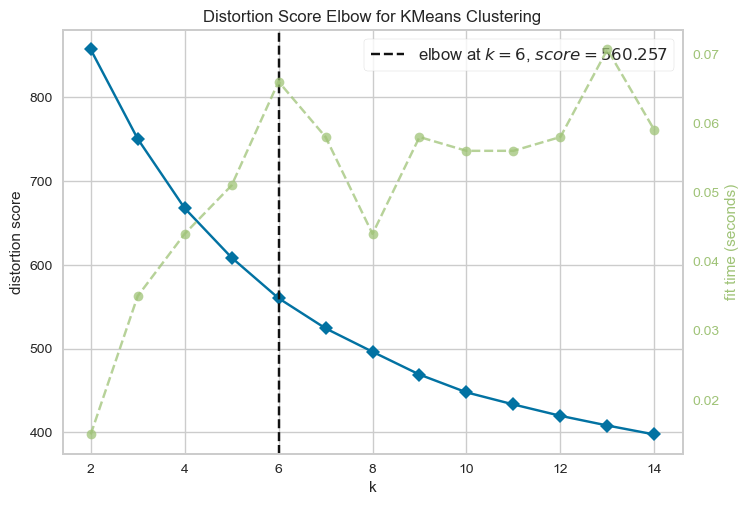

6


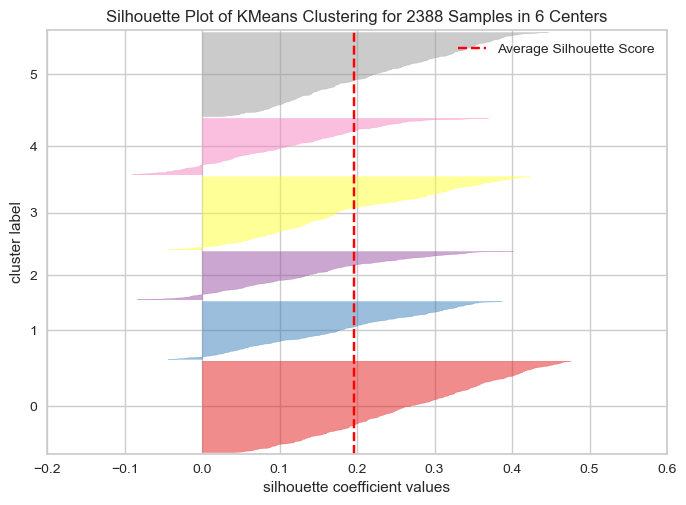

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 2388 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [92]:
# 加载数据
X4 = x_train_form4

# 定义KMeans模型
model4 = KMeans()

# 使用elbow方法确定最佳的k值
visualizer = KElbowVisualizer(model4, k=(2,15))
visualizer.fit(X4)
visualizer.show()

# 根据最佳的k值进行聚类
best_k = visualizer.elbow_value_
print(best_k)
model_k4 = KMeans(n_clusters=best_k)
model_k4.fit(X4)

# 可视化聚类结果
visualizer = SilhouetteVisualizer(model_k4)
visualizer.fit(X4)
visualizer.show()


In [93]:
# 获取聚类结果
y_train_form4 = model_k4.labels_
y_train_form4

array([0, 0, 0, ..., 3, 0, 0])

In [94]:
# 查看y_train_form2中各个类别的数量
pd.Series(y_train_form4).value_counts()

0    531
5    488
3    425
1    336
4    328
2    280
dtype: int64

In [95]:
data_all4 = add_form(data_all = data_all4, form_data = y_train_form4)

In [96]:
x_train4, y_train4, x_val4, y_val4, x_test4, y_test4 = spiltData(data_all4, y_index=close_index, train_scale=0.7, val_scale=0.2, test_scale=0.1)
print("x_train.shape:",x_train4.shape," y_train.shape:",y_train4.shape,"\n",
      "x_val.shape:",x_val4.shape," y_val.shape:",y_val4.shape,"\n",
      "x_test.shape:",x_test4.shape," y_test.shape:",y_test4.shape)

x_train.shape: (1657, 20, 61)  y_train.shape: (1657,) 
 x_val.shape: (474, 20, 61)  y_val.shape: (474,) 
 x_test.shape: (237, 20, 61)  y_test.shape: (237,)


In [97]:
# 查看所有训练集、验证集、测试集合的shape
print("----------Model1: 基础价量数据----------")
print(x_train1.shape, y_train1.shape, x_val1.shape, y_val1.shape, x_test1.shape, y_test1.shape)
print("\n")
print("----------Model2: 基础价量 + 价格形态数据----------")
print(x_train2.shape, y_train2.shape, x_val2.shape, y_val2.shape, x_test2.shape, y_test2.shape)
print("\n")
print("----------Model3: 基础价量 + 宏观经济数据----------")
print(x_train3.shape, y_train3.shape, x_val3.shape, y_val3.shape, x_test3.shape, y_test3.shape)
print("\n")
print("----------Model4: 基础价量 + 价格形态 + 宏观经济数据----------")
print(x_train4.shape, y_train4.shape, x_val4.shape, y_val4.shape, x_test4.shape, y_test4.shape)

print("\n")
print("\n")

# 查看所有数据是否有nan
print("----------Model1: 基础价量数据----------")
print(np.isnan(x_train1).any(), np.isnan(y_train1).any(), np.isnan(x_val1).any(), np.isnan(y_val1).any(), np.isnan(x_test1).any(), np.isnan(y_test1).any())
print("\n")
print("----------Model2: 基础价量 + 价格形态数据----------")
print(np.isnan(x_train2).any(), np.isnan(y_train2).any(), np.isnan(x_val2).any(), np.isnan(y_val2).any(), np.isnan(x_test2).any(), np.isnan(y_test2).any())
print("\n")
print("----------Model3: 基础价量 + 宏观经济数据----------")
print(np.isnan(x_train3).any(), np.isnan(y_train3).any(), np.isnan(x_val3).any(), np.isnan(y_val3).any(), np.isnan(x_test3).any(), np.isnan(y_test3).any())
print("\n")
print("----------Model4: 基础价量 + 价格形态 + 宏观经济数据----------")
print(np.isnan(x_train4).any(), np.isnan(y_train4).any(), np.isnan(x_val4).any(), np.isnan(y_val4).any(), np.isnan(x_test4).any(), np.isnan(y_test4).any())


----------Model1: 基础价量数据----------
(1687, 20, 5) (1687,) (482, 20, 5) (482,) (241, 20, 5) (241,)


----------Model2: 基础价量 + 价格形态数据----------
(1673, 20, 11) (1673,) (478, 20, 11) (478,) (239, 20, 11) (239,)


----------Model3: 基础价量 + 宏观经济数据----------
(1671, 20, 55) (1671,) (478, 20, 55) (478,) (239, 20, 55) (239,)


----------Model4: 基础价量 + 价格形态 + 宏观经济数据----------
(1657, 20, 61) (1657,) (474, 20, 61) (474,) (237, 20, 61) (237,)




----------Model1: 基础价量数据----------
False False False False False False


----------Model2: 基础价量 + 价格形态数据----------
False False False False False False


----------Model3: 基础价量 + 宏观经济数据----------
False False False False False False


----------Model4: 基础价量 + 价格形态 + 宏观经济数据----------
False False False False False False


# 模型部分

In [98]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [99]:
class myLSTM(nn.Module):
    def __init__(self, lstm_input_size, hidden_size, fc1_outputsize, num_layers, lstm_output_size=1):
        super(myLSTM, self).__init__()
        self.lstm_inputsize = lstm_input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.fc1_outputsize = fc1_outputsize

        # LSTM
        self.lstm = nn.LSTM(input_size=lstm_input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, fc1_outputsize)
        self.relu_1 = nn.ReLU()
        self.fc2 = nn.Linear(fc1_outputsize, lstm_output_size)


    def forward(self, lstm_x):
        if device.type == "cuda":
            lstm_x = lstm_x.cuda()
        # LSTM
        h0 = torch.zeros(self.num_layers, lstm_x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, lstm_x.size(0), self.hidden_size).to(device)
        # Forward propagate LSTM
        l_out, hidden = self.lstm(lstm_x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        l_out = l_out[:, -1, :]
        l_out = self.fc1(l_out)
        l_out = self.relu_1(l_out)
        l_out = self.fc2(l_out)
        return l_out

In [100]:
def load_data(x_train, y_train, x_val, y_val, x_test, y_test):
    train_dataset = TensorDataset(torch.from_numpy(x_train).to(torch.float32), torch.from_numpy(y_train).to(torch.float32))
    val_dataset=TensorDataset(torch.from_numpy(x_val).to(torch.float32), torch.from_numpy(y_val).to(torch.float32))
    test_dataset = TensorDataset(torch.from_numpy(x_test).to(torch.float32), torch.from_numpy(y_test).to(torch.float32))


    with FileLock(os.path.expanduser("~/.data.lock")):
        trainset = train_dataset
        val_dataset = val_dataset
        testset = test_dataset
    return trainset, val_dataset, testset

In [101]:
def train_cifar(config, x_train, y_train, x_val, y_val, x_test, y_test):

    train_dataset,val_dataset, _ = load_data(x_train, y_train, x_val, y_val, x_test, y_test)

    model = myLSTM(lstm_input_size=x_train.shape[2], hidden_size=config["hidden_size"],
                   fc1_outputsize=config["fc1_outputsize"], num_layers=config["num_layers"]).to(device)

    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])


    # To restore a checkpoint, use `session.get_checkpoint()`.
    loaded_checkpoint = session.get_checkpoint()
    if loaded_checkpoint:
        with loaded_checkpoint.as_directory() as loaded_checkpoint_dir:
            model_state, optimizer_state = torch.load(os.path.join(loaded_checkpoint_dir, "checkpoint.pt"))
            model.load_state_dict(model_state)
            optimizer.load_state_dict(optimizer_state)
    


    trainloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        drop_last=True,
        num_workers=2)
    valloader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        drop_last=True,
        num_workers=2)

    train_losses=[]
    val_losses=[]
    #训练部分
    for epoch in range(config["num_epochs"]):
        model.train()
        epoch_steps = 0
        train_loss = 0.0

        for (x, y) in  trainloader:
            if device.type == "cuda":
                x = x.cuda()
                y = y.cuda()
            # Forward pass
            output = model(x)
            loss = loss_fn(output, y)
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Accumulate the training loss
            train_loss += loss.item()
            epoch_steps += 1

        # print(train_loss)
        train_losses.append(train_loss)


        val_steps=0
        val_loss_=0.0
        model.eval()
        for (x, y)in valloader:
            if device.type == "cuda":
                x = x.cuda()
                y = y.cuda()
            output = model(x)
            loss_ = loss_fn(output, y)


            # Accumulate the validation loss
            val_loss_+= loss_.item()
            val_steps += 1
        # Append the epoch metrics to the lists
        val_losses.append(val_loss_)

        print(f'Epoch: {epoch}, Training loss: {train_loss:.4f}, Validation loss: {val_loss_:.4f}')
        os.makedirs("my_model", exist_ok=True)
        torch.save(
            (model.state_dict(), optimizer.state_dict()),
            os.path.join("my_model", "checkpoint.pt"),
        )
        checkpoint = Checkpoint.from_directory("my_model")
        session.report({"loss": (val_loss_ / val_steps)}, checkpoint=checkpoint)
    print("Finished Training")

In [102]:
#可视化函数
def plot(real,predictions):
    plt.figure(figsize=(15,8),dpi=150)
    plt.plot(real, label='Real',color = "blue")
    plt.plot(predictions, label='Pred',color = "red")
    plt.legend()
    plt.show()

In [103]:
def test_best_model(best_result, x_train, y_train, x_val, y_val, x_test, y_test):

    _, _, test_dataset = load_data(x_train, y_train, x_val, y_val, x_test, y_test)
    best_trained_model = myLSTM(lstm_input_size=x_train.shape[2], hidden_size=best_result.config["hidden_size"],
                   fc1_outputsize=best_result.config["fc1_outputsize"], num_layers=best_result.config["num_layers"])
    # device = "cuda:0" if torch.cuda.is_available() else "cpu"
    best_trained_model.to(device)

    checkpoint_path = os.path.join(best_result.checkpoint.to_directory(), "checkpoint.pt")
    model_state, optimizer_state = torch.load(checkpoint_path)
    best_trained_model.load_state_dict(model_state)

    # testloader = torch.utils.data.DataLoader(
    #     test_dataset, batch_size=1, shuffle=False,drop_last=True, num_workers=2)

    best_trained_model.eval()
    predictions = []
    with torch.no_grad():
        for (x, y) in test_dataset:
            if device.type == "cuda":
                x = x.cuda()
                y = y.cuda()
            outputs =  best_trained_model(x.reshape((1,x_train.shape[1],x_train.shape[2])))
            predictions.append(outputs.item())


    return predictions,best_trained_model

In [104]:
config = {
    "hidden_size": tune.sample_from(lambda _: 2**np.random.randint(2, 9)),
    "fc1_outputsize": tune.sample_from(lambda _: 2**np.random.randint(2, 9)),
    "num_layers": tune.choice([1,2]),
    "lr": tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([16,32,64]),
    "num_epochs":tune.choice([20,35,50]),
}

In [105]:
def main(config,
         x_train, y_train, x_val, y_val, x_test, y_test,
         num_samples=50,max_num_epochs=50,gpus_per_trial=0,
         ):
    
    scheduler=ASHAScheduler(
         max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)

    tuner = tune.Tuner(
        tune.with_resources(
            tune.with_parameters(train_cifar,  x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, x_test=x_test, y_test=y_test),
            resources={"cpu": 2, "gpu":gpus_per_trial}
        ),
        tune_config=tune.TuneConfig(
            metric="loss",
            mode="min",
            scheduler=scheduler,
            num_samples=num_samples,
        ),
        param_space=config,
    )
    results = tuner.fit()

    print("-----------------------------------------------------------")
   # 找出最佳实验
    best_result = results.get_best_result("loss", "min")

    print("Best trial config: {}".format(best_result.config))
    print("Best trial final validation loss: {}".format(
        best_result.metrics["loss"]))
    predictions, best_model=test_best_model(best_result, x_train, y_train, x_val, y_val, x_test, y_test)

    return predictions,best_model


In [106]:
predictions1, best_model1 = main(config,
                             x_train = x_train1, y_train = y_train1, x_val = x_val1, y_val = y_val1, x_test = x_test1, y_test = y_test1,
                             num_samples=50,max_num_epochs=50,gpus_per_trial=0)

# torch.save(best_model1.state_dict(), "best_model1.pth")
# 反归一化
predictions1 = np.array(predictions1)*(y_max1-y_min1)+y_min1
y_test1 = y_test1*(y_max1-y_min1)+y_min1

# 评价指标
print("---------------------------------评价指标---------------------------------")
print("MAE:",mean_absolute_error(y_test1, predictions1))
print("MSE:",mean_squared_error(y_test1, predictions1))
print("RMSE:",np.sqrt(mean_squared_error(y_test1, predictions1)))
print("R2:",r2_score(y_test1, predictions1))

# 可视化
print("---------------------------------预测效果---------------------------------")
plot(y_test1, predictions1)


(train_cifar pid=39028) c:\Users\16963\.conda\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
(train_cifar pid=39028)   return F.mse_loss(input, target, reduction=self.reduction)


Trial name,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,loss,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_cifar_7a7d3_00000,2023-11-12_13-10-29,True,,91a2b6187c6e428aa040a14f34bcebdd,LAPTOP-4OM1CA5D,20,0.154787,127.0.0.1,39028,True,132.827,7.1199,132.827,1699765829,0,,20,7a7d3_00000,0.00399971
train_cifar_7a7d3_00001,2023-11-12_13-08-42,True,,8d0308ff56ef4a129343f40e7303c092,LAPTOP-4OM1CA5D,2,0.162369,127.0.0.1,21804,True,21.0371,10.8659,21.0371,1699765722,0,,2,7a7d3_00001,0.00800061
train_cifar_7a7d3_00002,2023-11-12_13-08-41,True,,30a1232a4de94f65b0861b2a5fb92f02,LAPTOP-4OM1CA5D,2,0.164993,127.0.0.1,5140,True,19.5097,10.8511,19.5097,1699765721,0,,2,7a7d3_00002,0.0773027
train_cifar_7a7d3_00003,2023-11-12_13-08-33,True,,be7e9435f4d846a0b0d19697da1cdd2c,LAPTOP-4OM1CA5D,2,0.160639,127.0.0.1,48280,True,12.3018,5.77343,12.3018,1699765713,0,,2,7a7d3_00003,0.00698972
train_cifar_7a7d3_00004,2023-11-12_13-08-39,True,,be7e9435f4d846a0b0d19697da1cdd2c,LAPTOP-4OM1CA5D,1,0.18373,127.0.0.1,48280,True,5.56119,5.56119,5.56119,1699765719,0,,1,7a7d3_00004,0.00698972
train_cifar_7a7d3_00005,2023-11-12_13-08-45,True,,be7e9435f4d846a0b0d19697da1cdd2c,LAPTOP-4OM1CA5D,1,0.143362,127.0.0.1,48280,True,5.95917,5.95917,5.95917,1699765725,0,,1,7a7d3_00005,0.00698972
train_cifar_7a7d3_00006,2023-11-12_13-08-48,True,,30a1232a4de94f65b0861b2a5fb92f02,LAPTOP-4OM1CA5D,1,0.144662,127.0.0.1,5140,True,7.02199,7.02199,7.02199,1699765728,0,,1,7a7d3_00006,0.0773027
train_cifar_7a7d3_00007,2023-11-12_13-08-49,True,,8d0308ff56ef4a129343f40e7303c092,LAPTOP-4OM1CA5D,1,0.151534,127.0.0.1,21804,True,6.8365,6.8365,6.8365,1699765729,0,,1,7a7d3_00007,0.00800061
train_cifar_7a7d3_00008,2023-11-12_13-16-15,True,,be7e9435f4d846a0b0d19697da1cdd2c,LAPTOP-4OM1CA5D,50,0.157374,127.0.0.1,48280,True,449.577,5.52919,449.577,1699766175,0,,50,7a7d3_00008,0.00698972
train_cifar_7a7d3_00009,2023-11-12_13-08-53,True,,30a1232a4de94f65b0861b2a5fb92f02,LAPTOP-4OM1CA5D,1,0.558979,127.0.0.1,5140,True,5.31246,5.31246,5.31246,1699765733,0,,1,7a7d3_00009,0.0773027


(train_cifar pid=39028) Epoch: 0, Training loss: 4.8097, Validation loss: 4.2419


(train_cifar pid=21804) c:\Users\16963\.conda\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
(train_cifar pid=21804)   return F.mse_loss(input, target, reduction=self.reduction)
(train_cifar pid=48280) c:\Users\16963\.conda\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
(train_cifar pid=48280)   return F.mse_loss(input, target, reduction=self.reduction)
(train_cifar pid=5140) c:\Users\16963\.conda\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([64])) that is different to the input

(train_cifar pid=48280) Epoch: 0, Training loss: 1.2095, Validation loss: 0.9544
(train_cifar pid=39028) Epoch: 1, Training loss: 3.4499, Validation loss: 4.3380
(train_cifar pid=5140) Epoch: 0, Training loss: 16.2378, Validation loss: 0.7675
(train_cifar pid=21804) Epoch: 0, Training loss: 11.4980, Validation loss: 3.4650
(train_cifar pid=48280) Epoch: 1, Training loss: 0.8527, Validation loss: 1.1245
(train_cifar pid=39028) Epoch: 2, Training loss: 3.5254, Validation loss: 4.7699


(train_cifar pid=48280) c:\Users\16963\.conda\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
(train_cifar pid=48280)   return F.mse_loss(input, target, reduction=self.reduction)


(train_cifar pid=48280) Epoch: 0, Training loss: 3.7545, Validation loss: 2.7559
(train_cifar pid=39028) Epoch: 3, Training loss: 3.4713, Validation loss: 5.2676
(train_cifar pid=5140) Epoch: 1, Training loss: 0.8613, Validation loss: 1.1550
(train_cifar pid=21804) Epoch: 1, Training loss: 3.4845, Validation loss: 4.8711


(train_cifar pid=5140) c:\Users\16963\.conda\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
(train_cifar pid=5140)   return F.mse_loss(input, target, reduction=self.reduction)


(train_cifar pid=48280) Epoch: 0, Training loss: 1.8348, Validation loss: 1.0035
(train_cifar pid=39028) Epoch: 4, Training loss: 3.4404, Validation loss: 4.7186
(train_cifar pid=5140) Epoch: 0, Training loss: 3.6670, Validation loss: 4.3399
(train_cifar pid=21804) Epoch: 0, Training loss: 3.4139, Validation loss: 4.5460


(train_cifar pid=21804) c:\Users\16963\.conda\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
(train_cifar pid=21804)   return F.mse_loss(input, target, reduction=self.reduction)


(train_cifar pid=39028) Epoch: 5, Training loss: 3.4770, Validation loss: 3.8369
(train_cifar pid=5140) Epoch: 0, Training loss: 3.9583, Validation loss: 3.9129
(train_cifar pid=21804) Epoch: 0, Training loss: 1.1008, Validation loss: 1.3035


(train_cifar pid=5140) c:\Users\16963\.conda\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
(train_cifar pid=5140)   return F.mse_loss(input, target, reduction=self.reduction)


(train_cifar pid=5140) Epoch: 0, Training loss: 5.3745, Validation loss: 2.6297
(train_cifar pid=39028) Epoch: 6, Training loss: 3.4491, Validation loss: 5.0194
(train_cifar pid=48280) Epoch: 0, Training loss: 15.3886, Validation loss: 1.0350
(train_cifar pid=21804) Epoch: 0, Training loss: 2.2170, Validation loss: 1.4362
(train_cifar pid=39028) Epoch: 7, Training loss: 3.4676, Validation loss: 4.8969
(train_cifar pid=5140) Epoch: 0, Training loss: 4.9533, Validation loss: 5.6679
(train_cifar pid=21804) Epoch: 0, Training loss: 0.9470, Validation loss: 0.9978
(train_cifar pid=39028) Epoch: 8, Training loss: 3.4521, Validation loss: 4.6095
(train_cifar pid=21804) Epoch: 1, Training loss: 0.8741, Validation loss: 1.0915
(train_cifar pid=5140) Epoch: 0, Training loss: 1.9729, Validation loss: 1.0982
(train_cifar pid=48280) Epoch: 1, Training loss: 0.9916, Validation loss: 0.9578
(train_cifar pid=39028) Epoch: 9, Training loss: 3.4964, Validation loss: 5.1689
(train_cifar pid=21804) Epoch:

(train_cifar pid=21804) c:\Users\16963\.conda\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
(train_cifar pid=21804)   return F.mse_loss(input, target, reduction=self.reduction)


(train_cifar pid=21804) Epoch: 0, Training loss: 1.7958, Validation loss: 2.4233
(train_cifar pid=39028) Epoch: 11, Training loss: 3.4614, Validation loss: 4.4245
(train_cifar pid=5140) Epoch: 1, Training loss: 3.5052, Validation loss: 3.2254
(train_cifar pid=48280) Epoch: 3, Training loss: 0.8546, Validation loss: 1.0539
(train_cifar pid=39028) Epoch: 12, Training loss: 3.4527, Validation loss: 5.9121
(train_cifar pid=21804) Epoch: 0, Training loss: 4.3544, Validation loss: 4.8087
(train_cifar pid=39028) Epoch: 13, Training loss: 3.5234, Validation loss: 5.1346
(train_cifar pid=21804) Epoch: 0, Training loss: 3.5006, Validation loss: 5.0658
(train_cifar pid=5140) Epoch: 2, Training loss: 3.4834, Validation loss: 4.5189
(train_cifar pid=48280) Epoch: 4, Training loss: 0.8658, Validation loss: 1.1174
(train_cifar pid=39028) Epoch: 14, Training loss: 3.4689, Validation loss: 4.6829
(train_cifar pid=21804) Epoch: 0, Training loss: 3.7212, Validation loss: 4.5891
(train_cifar pid=5140) Epo

(train_cifar pid=39028) c:\Users\16963\.conda\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
(train_cifar pid=39028)   return F.mse_loss(input, target, reduction=self.reduction)


(train_cifar pid=5140) Epoch: 6, Training loss: 3.4829, Validation loss: 4.3102
(train_cifar pid=21804) Epoch: 6, Training loss: 3.4532, Validation loss: 4.2069
(train_cifar pid=39028) Epoch: 0, Training loss: 1.8299, Validation loss: 1.0502
(train_cifar pid=48280) Epoch: 8, Training loss: 0.8696, Validation loss: 1.4094
(train_cifar pid=21804) Epoch: 7, Training loss: 3.4115, Validation loss: 5.5196
(train_cifar pid=5140) Epoch: 7, Training loss: 3.4230, Validation loss: 4.2727
(train_cifar pid=21804) Epoch: 0, Training loss: 2.3833, Validation loss: 2.2883
(train_cifar pid=39028) Epoch: 1, Training loss: 0.8506, Validation loss: 1.4450
(train_cifar pid=48280) Epoch: 9, Training loss: 0.8660, Validation loss: 1.2572
(train_cifar pid=21804) Epoch: 0, Training loss: 2.8603, Validation loss: 2.9841
(train_cifar pid=39028) Epoch: 0, Training loss: 1.2849, Validation loss: 1.3447
(train_cifar pid=5140) Epoch: 8, Training loss: 3.4640, Validation loss: 4.7609
(train_cifar pid=48280) Epoch: 

(train_cifar pid=39028) c:\Users\16963\.conda\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
(train_cifar pid=39028)   return F.mse_loss(input, target, reduction=self.reduction)


(train_cifar pid=39028) Epoch: 0, Training loss: 2.1349, Validation loss: 2.1032
(train_cifar pid=48280) Epoch: 15, Training loss: 0.8711, Validation loss: 0.9067
(train_cifar pid=5140) Epoch: 14, Training loss: 3.4319, Validation loss: 4.1254
(train_cifar pid=21804) Epoch: 0, Training loss: 22.6125, Validation loss: 6.3463
(train_cifar pid=39028) Epoch: 1, Training loss: 1.7612, Validation loss: 2.3538
(train_cifar pid=21804) Epoch: 0, Training loss: 1.4045, Validation loss: 1.1584
(train_cifar pid=39028) Epoch: 2, Training loss: 1.7320, Validation loss: 2.7338
(train_cifar pid=5140) Epoch: 15, Training loss: 3.4260, Validation loss: 4.7963
(train_cifar pid=48280) Epoch: 16, Training loss: 0.8644, Validation loss: 1.1427
(train_cifar pid=21804) Epoch: 0, Training loss: 4.5497, Validation loss: 5.0808
(train_cifar pid=39028) Epoch: 3, Training loss: 1.7192, Validation loss: 2.6334
(train_cifar pid=5140) Epoch: 0, Training loss: 7.2667, Validation loss: 4.2173
(train_cifar pid=21804) Ep

2023-11-12 13:16:15,386	INFO tune.py:762 -- Total run time: 482.97 seconds (482.80 seconds for the tuning loop).


-----------------------------------------------------------
Best trial config: {'hidden_size': 4, 'fc1_outputsize': 128, 'num_layers': 1, 'lr': 0.0009482298058717339, 'batch_size': 64, 'num_epochs': 35}
Best trial final validation loss: 0.14336243271827698


TypeError: can't multiply sequence by non-int of type 'numpy.float64'

In [ ]:
predictions2, best_model2 = main(config,
                             x_train = x_train2, y_train = y_train2, x_val = x_val2, y_val = y_val2, x_test = x_test2, y_test = y_test2,
                             num_samples=50,max_num_epochs=50,gpus_per_trial=0)

# torch.save(best_model2.state_dict(), "best_model2.pth")

# 反归一化
predictions2 = np.array(predictions2)*(y_max2-y_min2)+y_min2
y_test2 = y_test2*(y_max2-y_min2)+y_min2

# 评价指标
print("---------------------------------评价指标---------------------------------")
print("MAE:",mean_absolute_error(y_test2, predictions2))
print("MSE:",mean_squared_error(y_test2, predictions2))
print("RMSE:",np.sqrt(mean_squared_error(y_test2, predictions2)))
print("R2:",r2_score(y_test2, predictions2))

# 可视化
print("---------------------------------预测效果---------------------------------")
plot(y_test2, predictions2)



In [ ]:
predictions3, best_model3 = main(config,
                                x_train = x_train3, y_train = y_train3, x_val = x_val3, y_val = y_val3, x_test = x_test3, y_test = y_test3,
                                num_samples=50,max_num_epochs=50,gpus_per_trial=0)

# torch.save(best_model3.state_dict(), "best_model3.pth")

# 反归一化
predictions3 = np.arrary(predictions3)*(y_max3-y_min3)+y_min3
y_test3 = y_test3*(y_max3-y_min3)+y_min3

# 评价指标
print("---------------------------------评价指标---------------------------------")
print("MAE:",mean_absolute_error(y_test3, predictions3))
print("MSE:",mean_squared_error(y_test3, predictions3))
print("RMSE:",np.sqrt(mean_squared_error(y_test3, predictions3)))
print("R2:",r2_score(y_test3, predictions3))

# 可视化
print("---------------------------------预测效果---------------------------------")
plot(y_test3, predictions3)

In [ ]:
predictions4, best_model4 = main(config,
                                 x_train = x_train4, y_train = y_train4, x_val = x_val4, y_val = y_val4, x_test = x_test4, y_test = y_test4,
                                    num_samples=50,max_num_epochs=50,gpus_per_trial=0)

# torch.save(best_model4.state_dict(), "best_model4.pth")

# 反归一化
predictions4 = np.array(predictions4)*(y_max4-y_min4)+y_min4
y_test4 = y_test4*(y_max4-y_min4)+y_min4

# 评价指标
print("---------------------------------评价指标---------------------------------")
print("MAE:",mean_absolute_error(y_test4, predictions4))
print("MSE:",mean_squared_error(y_test4, predictions4))
print("RMSE:",np.sqrt(mean_squared_error(y_test4, predictions4)))
print("R2:",r2_score(y_test4, predictions4))

# 可视化
print("---------------------------------预测效果---------------------------------")
plot(y_test4, predictions4)

In [ ]:
import time
while True:
    time.sleep(200)
    print("上面的代码跑完啦")
